# Testing Notebook (Standalone)
This notebook tests the trained model on MNIST.

In [42]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
from e2cnn import gspaces
from e2cnn import nn as enn
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



import random, os
    

In [43]:
# Data preparation with balanced validation split
def get_dataloaders(batch_size=64, subset_fraction=1.0, seed=42):
    transform = transforms.Compose([
        transforms.RandomRotation(degrees=(-180, 180)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    full_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    
    if subset_fraction < 1.0:
        class_indices = {i: [] for i in range(10)}
        for idx, (_, label) in enumerate(full_dataset):
            class_indices[label].append(idx)
        samples_per_class = int((len(full_dataset) * subset_fraction) / 10)
        balanced_indices = [random.sample(class_indices[i], samples_per_class) for i in range(10)]
        balanced_indices = [item for sublist in balanced_indices for item in sublist]
        random.shuffle(balanced_indices)
        subset = Subset(full_dataset, balanced_indices)
    else:
        subset = full_dataset

    train_size = int(0.8 * len(subset))
    val_size = len(subset) - train_size
    train_set, val_set = random_split(subset, [train_size, val_size])

    test_set = datasets.MNIST('data', train=False, download=True, transform=transform)
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_set, batch_size=batch_size)
    )
    

In [44]:

# Re-define model for loading
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)
    

In [45]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [46]:
class RotEquivariantCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=8)

        in_type = enn.FieldType(r2_act, [r2_act.trivial_repr])
        self.input_type = in_type

        self.block1 = enn.SequentialModule(
            enn.R2Conv(
                in_type,
                enn.FieldType(r2_act, 8 * [r2_act.regular_repr]),
                kernel_size=5,
                padding=2,
                bias=False,
            ),
            enn.ReLU(enn.FieldType(r2_act, 8 * [r2_act.regular_repr]), inplace=True),
            enn.PointwiseMaxPool(
                enn.FieldType(r2_act, 8 * [r2_act.regular_repr]), kernel_size=2
            ),
        )

        self.block2 = enn.SequentialModule(
            enn.R2Conv(
                self.block1.out_type,
                enn.FieldType(r2_act, 16 * [r2_act.regular_repr]),
                kernel_size=5,
                padding=2,
                bias=False,
            ),
            enn.ReLU(enn.FieldType(r2_act, 16 * [r2_act.regular_repr]), inplace=True),
            enn.PointwiseMaxPool(
                enn.FieldType(r2_act, 16 * [r2_act.regular_repr]), kernel_size=2
            ),
        )

        c = self.block2.out_type.size
        self.fc1 = nn.Linear(c * 7 * 7, num_classes)

    def forward(self, x):
        x = enn.GeometricTensor(x, self.input_type)
        x = self.block1(x)
        x = self.block2(x)
        x = x.tensor
        x = x.view(x.size(0), -1)
        return self.fc1(x)

In [47]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            # inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    print("📊 Test Metrics")
    print(f"   Accuracy : {acc:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall   : {recall:.4f}")
    print(f"   F1 Score : {f1:.4f}")

    return y_true, y_pred

    

In [48]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    labels = list(range(10))  # Adjust for your dataset (e.g., digits 0–9)

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Normalize rows (true labels) to percentages
    cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100
    cm_percent = np.nan_to_num(cm_percent)  # avoid NaNs for any empty rows

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm_percent, interpolation="nearest", cmap=plt.cm.Blues)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Percentage (%)", rotation=-90, va="bottom")

    # Set axis labels and ticks
    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xlabel="Predicted label",
        ylabel="True label",
        title=f"Confusion Matrix (%) - {model_name}"
    )

    # Rotate tick labels for better display
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Annotate each cell with percentage value
    for i in range(len(labels)):
        for j in range(len(labels)):
            percentage = cm_percent[i, j]
            ax.text(
                j, i, f"{percentage:.1f}",
                ha="center", va="center",
                color="white" if percentage > 50 else "black"
            )

    plt.tight_layout()
    plt.show()



📊 Test Metrics
   Accuracy : 0.5104
   Precision: 0.4906
   Recall   : 0.5015
   F1 Score : 0.4871


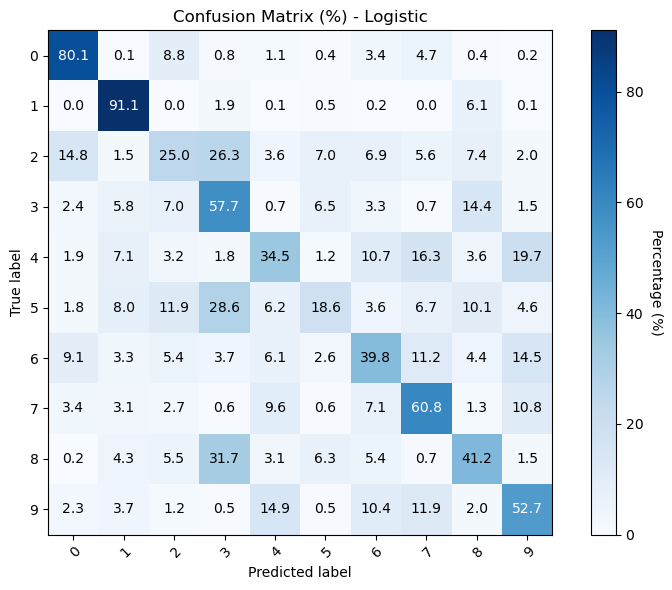

In [51]:
_, _, test_loader = get_dataloaders(subset_fraction=1.0)
# Load model
# Load and evaluate saved model
model = LogisticRegression()
model.load_state_dict(torch.load("logistic.pth", map_location=device))
model.to(device)
model.eval()

y_true, y_pred = evaluate_model(model, test_loader)
plot_confusion_matrix(y_true, y_pred, model_name="Logistic")


📊 Test Metrics
   Accuracy : 0.7949
   Precision: 0.8112
   Recall   : 0.7934
   F1 Score : 0.7901


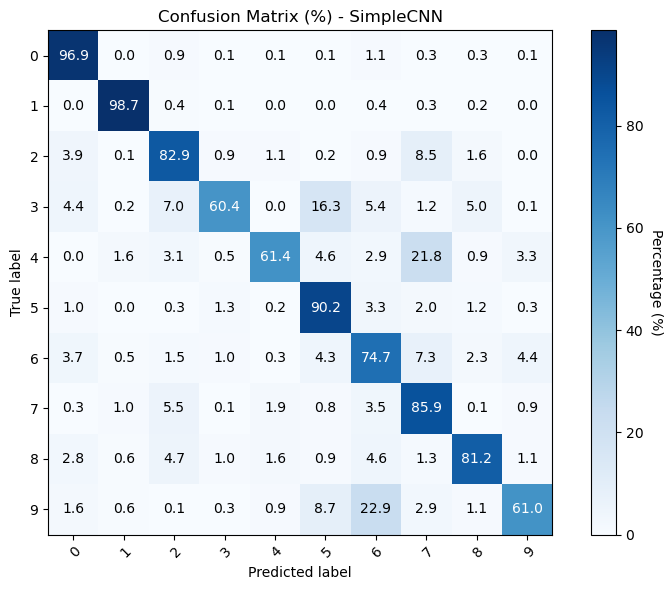

In [52]:
_, _, test_loader = get_dataloaders(subset_fraction=1.0)
# Load model
# Load and evaluate saved model
model = SimpleCNN()
model.load_state_dict(torch.load("cnn.pth", map_location=device))
model.to(device)
model.eval()

y_true, y_pred = evaluate_model(model, test_loader)
plot_confusion_matrix(y_true, y_pred, model_name="SimpleCNN")

In [ ]:
_, _, test_loader = get_dataloaders(subset_fraction=1.0)
# Load model
# Load and evaluate saved model
model = RotEquivariantCNN()
model.load_state_dict(torch.load("rotcnn.pth", map_location=device))
model.to(device)
model.eval()

y_true, y_pred = evaluate_model(model, test_loader)
plot_confusion_matrix(y_true, y_pred, model_name="RotCNN")

RuntimeError: Error(s) in loading state_dict for LogisticRegression:
	Missing key(s) in state_dict: "linear.weight", "linear.bias". 
	Unexpected key(s) in state_dict: "block1.0.weights", "block1.0.filter", "block1.0._basisexpansion.block_expansion_('irrep_0', 'regular').sampled_basis", "block2.0.weights", "block2.0.filter", "block2.0._basisexpansion.block_expansion_('regular', 'regular').sampled_basis", "fc1.weight", "fc1.bias". 